In [190]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/gauri-foundry/Desktop/eval_SME/sme-invoicing-assistant


In [192]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/gauri-foundry/Desktop/eval_SME/sme-invoicing-assistant/.env.example


True

In [193]:
import pandas as pd
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect("results/llama3.2-vision_11b-qwen2.5_72b/emails.db")
# conn = sqlite3.connect("src/data/db/llama3.2-vision_11b-qwen2.5_32b/emails.db")

# Write your SQL query
query = "SELECT * FROM emails"

# Read the query results into a pandas DataFrame
df = pd.read_sql(query, conn)

df.head(5)

,email_id,sender_email,recipient_email,subject,email_body,attachments,process_status,response,start_time,end_time,total_time,successful_requests,total_tokens,prompt_tokens,completion_tokens,total_cost
0,93185A89130149C0A842968E4AFDCAA2,RobinLevine@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 43925,Hi Tanya ! Please find attached payment screen...,transaction_1.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-20T21:08:52.132058,2025-01-20T21:09:48.709388,56.5773,8,2669,2273,396,0.0
1,614972488B7B411BAEA4814CF066CDAA,StevenNixon@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 51782,Hi Tanya ! Please find attached payment screen...,transaction_2.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-20T21:09:48.718054,2025-01-20T21:10:49.748750,61.0307,28,9970,8395,1575,0.0
2,C484ABEB38F44D29960B1CEF58510627,MadisonFord@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 42968,Hi Tanya ! Please find attached payment screen...,transaction_3.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-20T21:10:49.756916,2025-01-20T21:11:49.322336,59.5654,60,22143,18487,3656,0.0
3,706B3403E8024178948B3BFBF9E64A25,KathrynJones@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 92948,Hi Tanya ! Please find attached payment screen...,transaction_4.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-20T21:11:49.332251,2025-01-20T21:12:59.537244,70.2050,104,39615,32866,6749,0.0
4,86838440CA6C472AACFA3FCE1382609C,ChristineOwens@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 20304,Hi Tanya ! Please find attached payment screen...,transaction_5.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-20T21:12:59.546452,2025-01-20T21:13:51.116058,51.5696,160,62190,51439,10751,0.0


In [194]:
# Code to filter and remove repeated Invoice ID specific data from emails db
error_df = df.loc[df["process_status"] == "ERROR", ["response", "email_id"]]
ground_truth_df = pd.read_csv("./src/data/synthetic_data/ground_truth_data.csv")
ground_truth_df.head()
matching_rows = ground_truth_df[ground_truth_df["email_id"].isin(error_df["email_id"])]
# print(matching_rows)
error_df = error_df.merge(
    matching_rows[["email_id", "invoice_id", "amount"]], on="email_id", how="left"
)
transactions_df = pd.read_csv("./src/data/synthetic_data/transactions.csv")
ground_truth_df = pd.read_csv("./ground_truth_data 2.csv")
duplicate_rows = transactions_df[transactions_df["invoice_id"].duplicated(keep=False)]
# print(duplicate_rows)
num_duplicates = transactions_df["invoice_id"].duplicated().sum()
# print(f"Number of duplicate invoice_ids: {num_duplicates}")
duplicated_invoice_ids = transactions_df[
    transactions_df["invoice_id"].duplicated(keep=False)
]["invoice_id"].unique()
print("Unique duplicated invoice_ids:")
print(duplicated_invoice_ids)
matched_rows_emailid = ground_truth_df[
    ground_truth_df["invoice_id"].isin(duplicated_invoice_ids)
]
email_id_associated_with_duplicated_invoice_id = matched_rows_emailid[
    "email_id"
].tolist()
# print(email_id_associated_with_duplicated_invoice_id)
# print(len(email_id_associated_with_duplicated_invoice_id))

Unique duplicated invoice_ids:
['47535' '83211' '33011' '32831' '78443' 'I20283' 'I17919' 'I19555'
 'I13830' 'I15694' 'I11539' 'I12224' 'I11959' 'I15130' 'I13807' 'I16375'
 'I15190' 'I16935' 'I18364' 'I18536' 'I11126' 'I15903' 'I15165' 'I12970'
 'I15573' 'I14987' 'I13368' 'I20256' 'I17489' 'I12089' 'I19233' 'I14854'
 'I17006' 'I17250' 'I13980' 'I12734' 'I20809' 'I20544' 'I10079' 'I17774'
 'I18754' 'I16990' 'I19919' 'I15684' 'I19904' 'I14215' 'I11364' 'I13212'
 'I13346' 'I15199' 'I16771' 'I16433']


Note : Email id is unique but email id associated with Invoice id is not unique 
To identify any  any data row uniquely we need combination of email_id +invoice id

In [195]:
## DF without repeated Invoice ID's
df_filtered = df[~df["email_id"].isin(email_id_associated_with_duplicated_invoice_id)]

In [196]:
print(df_filtered.describe())

                                email_id              sender_email  \
count                               1895                      1895   
unique                              1895                      1883   
top     93185A89130149C0A842968E4AFDCAA2  MichaelJones@example.com   
freq                                   1                         3   

                     recipient_email  \
count                           1895   
unique                             1   
top     tanya.official.456@gmail.com   
freq                            1895   

                                           subject  \
count                                         1895   
unique                                        1895   
top     Payment Confirmation for Invoice ID: 43925   
freq                                             1   

                                               email_body attachments  \
count                                                1895        1895   
unique                         

In [197]:
import matplotlib.pyplot as plt


def plot_value_distribution(df_filtered, col="category", top_n=10):
    df_filtered[col].value_counts()[:top_n].plot(kind="bar")
    plt.title(f"Distribution of {col}")

    # add the count on top of the bars
    for i in range(len(df_filtered[col].value_counts()[:top_n])):
        count = df_filtered[col].value_counts().values[i]
        plt.text(i, count, count, ha="center")

    plt.show()

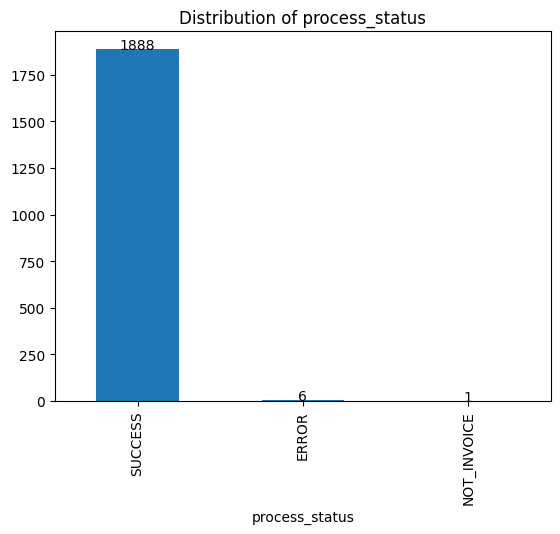

In [198]:
plot_value_distribution(df_filtered, "process_status")

In [199]:
error_df = df_filtered[df_filtered["process_status"] == "ERROR"]

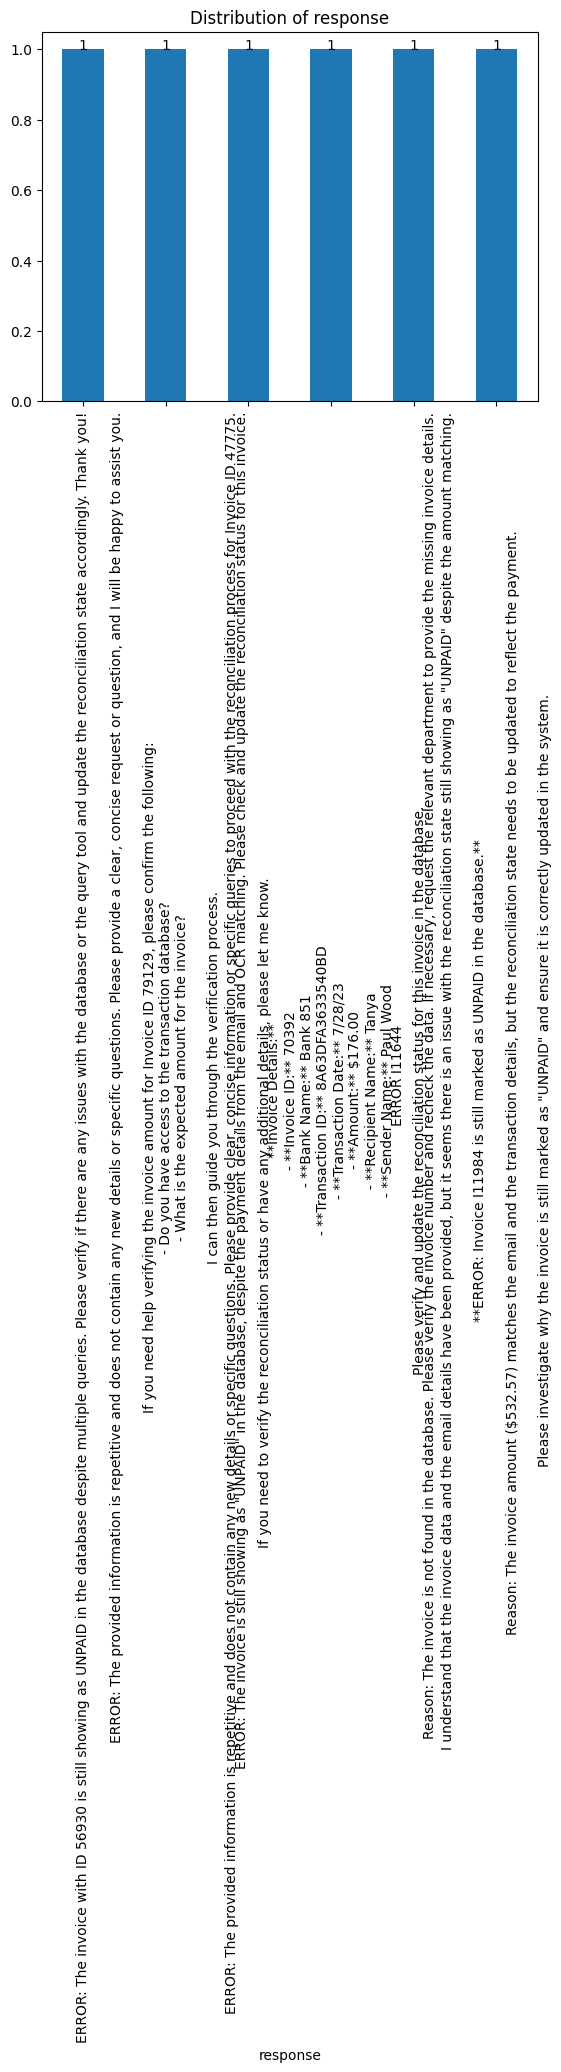

In [200]:
plot_value_distribution(error_df, "response")

In [201]:
error_df.to_csv(
    "results/llama3.2-vision_11b-qwen2.5_72b/error_analysis_llama3.2-vision_11b-qwen2.5_72b.csv"
)

In [202]:
df_filtered.columns

Index(['email_id', 'sender_email', 'recipient_email', 'subject', 'email_body',
       'attachments', 'process_status', 'response', 'start_time', 'end_time',
       'total_time', 'successful_requests', 'total_tokens', 'prompt_tokens',
       'completion_tokens', 'total_cost'],
      dtype='object')

In [203]:
df_filtered["end_time"] = pd.to_datetime(df["end_time"])
df_filtered["start_time"] = pd.to_datetime(df["start_time"])
df_filtered["duration"] = (
    df_filtered["end_time"] - df_filtered["start_time"]
).dt.total_seconds()
df_filtered[["duration", "total_time"]].head()

/var/folders/kf/04zlrrtd12g3fyn7mdz7cnk00000gn/T/ipykernel_1042/781749110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["end_time"] = pd.to_datetime(df["end_time"])
/var/folders/kf/04zlrrtd12g3fyn7mdz7cnk00000gn/T/ipykernel_1042/781749110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["start_time"] = pd.to_datetime(df["start_time"])
/var/folders/kf/04zlrrtd12g3fyn7mdz7cnk00000gn/T/ipykernel_1042/781749110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

,duration,total_time
0,56.577330,56.5773
1,61.030696,61.0307
2,59.565420,59.5654
3,70.204993,70.2050
4,51.569606,51.5696


<Axes: ylabel='Frequency'>

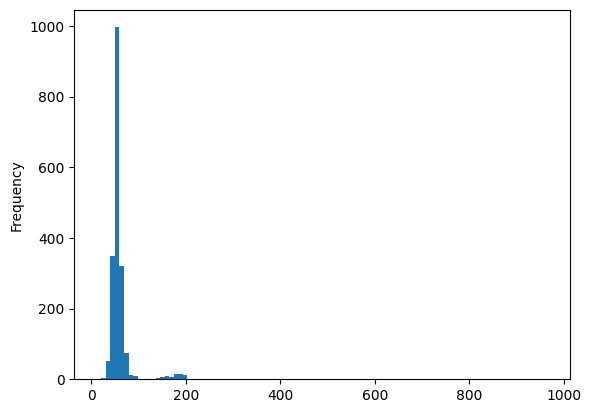

In [204]:
# plot the distribution of duration
df_filtered["duration"].plot(kind="hist", bins=100)

In [205]:
df_filtered["duration"].describe()

count    1895.000000
mean       60.416062
std        33.683641
min        12.329846
25%        50.729002
50%        52.763640
75%        60.224094
max       966.398515
Name: duration, dtype: float64

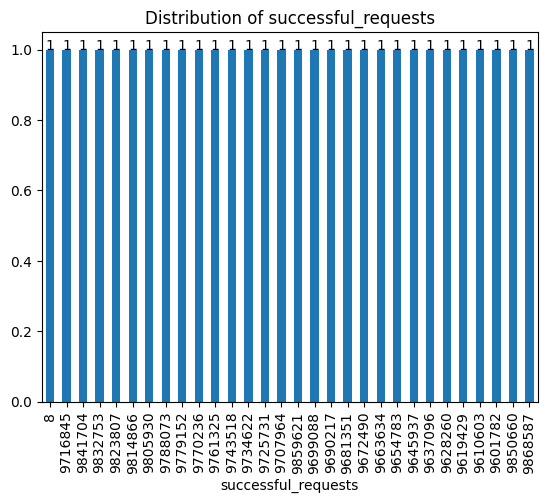

In [206]:
plot_value_distribution(df_filtered, "successful_requests", top_n=30)

In [207]:
df_filtered["process_status"].value_counts()

process_status
SUCCESS        1888
ERROR             6
NOT_INVOICE       1
Name: count, dtype: int64

** Success Rate **

In [208]:
success_rate = df_filtered["process_status"].value_counts()["SUCCESS"] / len(
    df_filtered
)
success_rate

0.9963060686015831

** Idle Power **

In [209]:
def total_power_in_watt(file_path):
    df = pd.read_csv(file_path)
    return df["CPU Package Power [W]"].mean() + df["GPU Power [W]"].mean()


power_idle = total_power_in_watt("results/power_idle.csv")
power_idle

29.873

** Power with and Without Vision **

In [210]:
power_with_vision = total_power_in_watt(
    "results/llama3.2-vision_11b-qwen2.5_72b/power_with_vision.csv"
)
power_without_vision = total_power_in_watt(
    "results/llama3.2-vision_11b-qwen2.5_72b/power_without_vision.csv"
)
power_with_vision, power_without_vision

(314.514, 313.5394)

** Mean Response Time **

In [211]:
mean_response_time = df_filtered["duration"].mean()
mean_response_time

60.416061722427436

** Average Energy Consumption **

In [212]:
average_energy_consumption = (
    (power_with_vision + power_without_vision) / 2 - power_idle
) * mean_response_time
average_energy_consumption

17167.44747785613

In [213]:
df_filtered.describe()

,start_time,end_time,duration
count,1895,1895,1895.000000
mean,2025-01-21 14:29:23.020890368,2025-01-21 14:30:23.436952064,60.416062
min,2025-01-20 21:08:52.132058,2025-01-20 21:09:48.709388,12.329846
25%,2025-01-21 05:56:28.870245120,2025-01-21 05:57:29.176482048,50.729002
50%,2025-01-21 15:14:11.122661120,2025-01-21 15:15:01.857776896,52.763640
75%,2025-01-21 22:47:52.020591616,2025-01-21 22:48:41.442115328,60.224094
max,2025-01-22 23:48:35.237256,2025-01-22 23:49:24.802621,966.398515
std,NaN,NaN,33.683641


In [214]:
row = df_filtered[df_filtered["process_status"] == "NOT_INVOICE"].iloc[0]
row

email_id                                8D2F793315854E01ADD4A7A552BE478D
sender_email                                   SherriDaniels@example.com
recipient_email                             tanya.official.456@gmail.com
subject                       Payment Confirmation for Invoice ID: 30509
email_body             Hi Tanya ! Please find attached payment screen...
attachments                                         transaction_493.jpeg
process_status                                               NOT_INVOICE
response               NA - The email and OCR data do not contain the...
start_time                                    2025-01-21 06:13:11.022480
end_time                                      2025-01-21 06:13:44.187156
total_time                                                       33.1647
successful_requests                                              1786806
total_tokens                                                   904103279
prompt_tokens                                      

*** Observations ***
1. Total 6 Error Cases Found 
2. Out of 6 - 2 Errors are LLM hallucniation Error 
3. 4 Errors are due to DB locking 